# Parameter study and thresholds

### Initialization

In [2]:
import os
os.environ['GRASPDATA'] = '/media/pietrof/s820/BINCAT/data'

join = os.path.join
import grasp
import numpy as np

import matplotlib.pyplot as plt
gplt = grasp.plots

import matplotlib as mpl
import pandas as pd

dr3 = grasp.dr3()


            ..............
         ..:;;..:;;;;;:::::;;
       ;;;;;;::.::;;;;;;;;;;;;;
      ;;;;.:;;;..;XXXXXX.::....:           GAIA QUERY MODULE
     :;::;::..+XXXXXXXXX+:;;;;;;:
    ;::;:.:;;:XXXXXXXXXXX::::::::;        __ _  __ _(_) __ _
    .;;..;;;:.:XXXXXXXXX$$$$$$$$$$X.     / _` |/ _` | |/ _` |
    :;..:;;;..:xXXXXXXX$$$$$$$$$$$$X    | (_| | (_| | | (_| |
    :;:.:;;.XXXXXXXXX$$$$$$$$$$$$$$;     \__, |\__,_|_|\__,_|
    .;;:.:X$$$$$$$$$$$$$$$$$$$$$$X.      |___/
    ..:;:$$$$$$$$$$$$$$$$$$$$$$X;.
     :;;;$$$$$$$$$$$$$$$$$$$$::;;             INITIALIZED
      ...;$$$$$$$$$$$$$$x;:;;;;;
        ......:;:....;;;;;;;:.
          ::::::::::;;;::...
            ....::::.....

Initialized with Gaia table: 'gaiadr3.gaia_source'


In [3]:
def generate_ra_dec_grid(step: float = 10.0) -> tuple[np.ndarray, np.ndarray]:
    """
    Generate a grid of RA and DEC coordinates covering the entire sky.

    Parameters
    ----------
    step : float, optional
        Step size in degrees for both RA and DEC (default is 10.0).

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        Arrays of RA and DEC coordinates (in degrees).
    """
    ra = np.arange(0, 360, step)
    dec = np.arange(-90, 91, step)
    ra_grid, dec_grid = np.meshgrid(ra, dec)
    return ra_grid.flatten(), dec_grid.flatten()

ra,dec = generate_ra_dec_grid(20.)

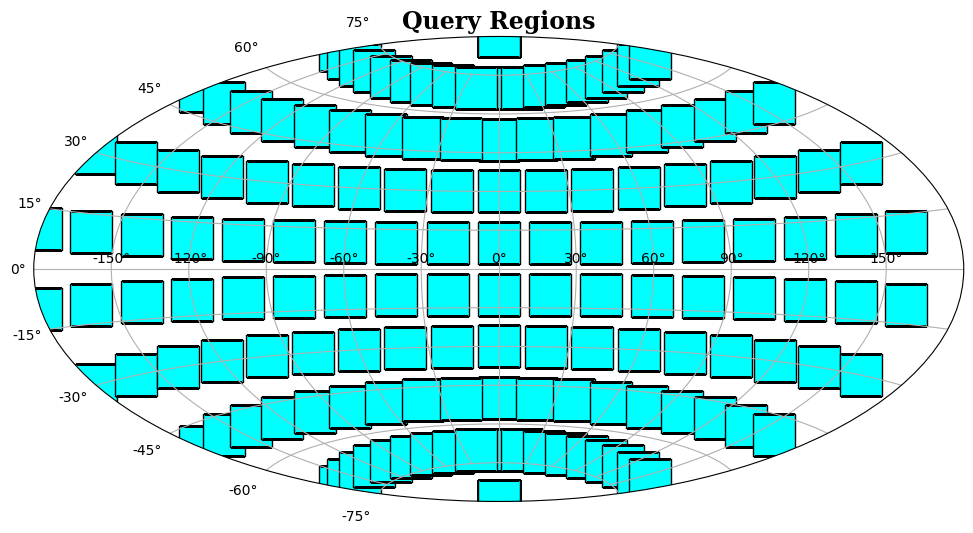

In [4]:
ra_rad = np.remainder(ra + 360 - 180, 360) - 180
ra_rad = np.deg2rad(ra_rad)
dec_rad = np.deg2rad(dec)

fig = plt.figure(figsize=(12, 6.4))
ax = fig.add_subplot(111, projection='aitoff')

# Scatter plot
ax.scatter(ra_rad, dec_rad, marker='s', s=917, color='cyan', edgecolor='k')

ax.set_title('Query Regions', fontdict=grasp.plots.title_font)
ax.grid(True)
plt.show()


### Query of the data (uncomment to do it)

```python
import gc

query = """SELECT source_id,ra,dec,ipd_gof_harmonic_amplitude,ipd_frac_multi_peak,ruwe,phot_g_mean_mag,non_single_star
FROM gaiadr3.gaia_source 
WHERE 
CONTAINS(
	POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),
	BOX('ICRS',{},{},{},{})
)=1"""

box_radius = 10.0  # degrees

coordra, coorddec = generate_ra_dec_grid(box_radius*2)

for ra,dec in zip(coordra, coorddec):
    print(f'Querying RA: {ra:.2f}, DEC: {dec:.2f}')
    data = dr3.free_query(query.format(ra, dec, box_radius, box_radius))
    
    data.meta['RA'] = (ra, 'Center RA coordinate of the query region in degrees')
    data.meta['DEC'] = (dec, 'Center DEC coordinate of the query region in degrees')
    data.meta['RADIUS'] = (box_radius, 'Radius of the query region in degrees')
    data.meta['GEOM'] = ('BOX', 'geometry of the query region')
    
    fn = join(grasp.gpaths.UNTRACKED_DATA_FOLDER, f'20250627_{int(ra):d}_{int(dec):d}.fits')
    data.write(fn, format='fits', overwrite=True)
    
    print(f"{len(data) = }")
    
    del data
    gc.collect()
```

### Load the data

In [5]:
coords = np.array([[r,d] for r,d in zip(ra,dec)], dtype=int)

In [6]:
filelist = grasp.core.osutils.get_file_list(fold=grasp.gpaths.UNTRACKED_DATA_FOLDER)[0]

base = filelist.split('/')[-1].split('_')[0] + "_{}_{}.fits"

In [8]:
class mpLoad():
    def __init__(self, data):
        self.RA = coords[0]
        self.DEC = coords[1]
        self.data = data.copy().to_pandas()
    def loadAndJoin(self, coords):
        RA = coords[0]
        DEC = coords[1]        
        data2 = grasp.load_data(
            filepath=join(grasp.gpaths.UNTRACKED_DATA_FOLDER, base.format(RA,DEC)),
            as_sample=True
        ).to_pandas()
        #self.data.join(data2, keep='both', inplace=True)
        self.data = self.data.merge(data2, how='outer')
        return self.data.copy()

data = grasp.load_data(
    filepath=join(grasp.gpaths.UNTRACKED_DATA_FOLDER, base.format(coords[0,0],coords[0,1])),
    as_sample=True
)

loader = mpLoad(data)
import multiprocessing as mp
with mp.Pool(8) as pool:
    fdata = pool.map(loader.loadAndJoin, coords)


# N = len(data)
# for RA,DEC in coords:
#     print(f"{(RA,DEC) = :} | {N = :,}", end='\r', flush=True)
#     data2 = grasp.load_data(
#         filepath=join(grasp.gpaths.UNTRACKED_DATA_FOLDER, base.format(RA,DEC)),
#         as_sample=True
#     )
#     data.join(data2, keep='both', inplace=True)
#     N += len(data2)

KeyboardInterrupt: 

In [12]:
from concurrent.futures import ThreadPoolExecutor
from os.path import join
from typing import Tuple, Any, List

def load_single_data(args: Tuple[float, float]) -> Any:
    """
    Load data for a single (RA, DEC) coordinate.

    Parameters
    ----------
    args : tuple
        Tuple containing (RA, DEC) coordinates.

    Returns
    -------
    Any
        Loaded data object.
    """
    RA, DEC = args
    return grasp.load_data(
        filepath=join(grasp.gpaths.UNTRACKED_DATA_FOLDER, base.format(RA, DEC)),
        as_sample=True
    )

coords_list: List[Tuple[float, float]] = [tuple(coord) for coord in coords]

with ThreadPoolExecutor() as executor:
    data_list = list(executor.map(load_single_data, coords_list))

data = data_list[0]
for data2 in data_list[1:]:
    data.join(data2, keep='both', inplace=True)

KeyboardInterrupt: 

In [ ]:
from astropy.coordinates import SkyCoord
from astropy import units as u
ra = data.to_numpy('ra')
dec = data.to_numpy('dec')

coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')
galactic_coords = coords.galactic

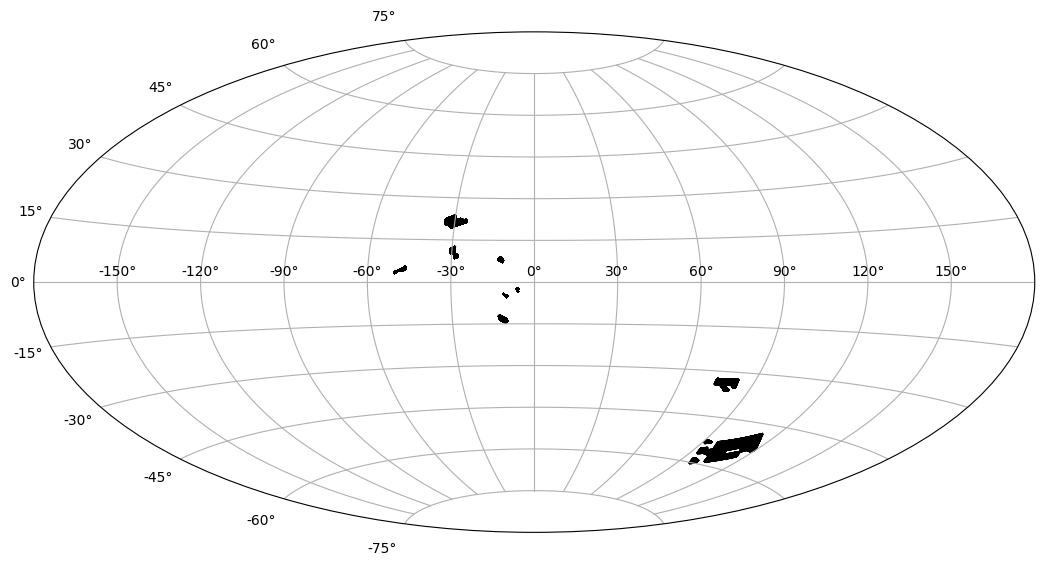

In [4]:
fig = plt.subplot(111, projection='aitoff')
fig.figure.set_size_inches(13, 6.5)
plt.grid(True)
plt.scatter(galactic_coords.l.wrap_at(180 * u.deg).radian,
            galactic_coords.b.radian,
            s=0.01, c='k', alpha=0.15, rasterized=True)

In [ ]:
mp_data = data.copy()
gof_data = data.copy()
ruwe_data = data.copy()

In [ ]:
mp_data.apply_conditions(['ipd_frac_multi_peak < 25', 'ipd_frac_multi_peak > 0'], inplace=True)

In [ ]:
print(len(mp_data))
gplt.histogram(mp_data.ipd_frac_multi_peak, bins=25, xlabel='ipd_frac_multi_peak', ylabel='Number of sources')

In [ ]:
grasp.stats.bootstrap_statistic(gof_data.ipd_gof_harmonic_amplitude, statistic_function=np.median, show_progress=True, n_bootstrap=int(np.sqrt(len(gof_data))/2))

In [ ]:
gof_data.reset_sample()

In [ ]:
gof_data.apply_conditions(['ipd_gof_harmonic_amplitude < 2', 'ipd_gof_harmonic_amplitude > 0'], inplace=True)

In [ ]:
gplt.histogram(gof_data.ipd_gof_harmonic_amplitude, xlabel='ipd_gof_harmonic_amplitude', ylabel='Number of sources', yscale='log')